In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils import data
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import zipfile

%matplotlib inline

In [2]:
base_data_dir = os.path.abspath('../../_data')
kmnist_dir = os.path.join(base_data_dir, 'Kannada-MNIST')
kmnist_data_dir = os.path.join(kmnist_dir, 'Kannada-MNIST-Data')
output_dir = os.path.join(kmnist_dir, 'Saved-Models')

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Download the competiotion datasets

In [4]:
# Downloading dataset
# if not os.path.exists(kmnist_data_dir):
#     ! kaggle competitions download -c Kannada-MNIST -p {base_data_dir}

In [5]:
# Extract the zip file
# if os.path.exists(kmnist_zip_file):
#     with zipfile.ZipFile(file=kmnist_zip_file, mode='r') as z:
#         z.extractall(kmnist_data_dir)

In [6]:
# Delete the downloaded zip file
# if os.path.exists(kmnist_zip_file):
#     ! rm {kmnist_zip_file}

### Load and investigate the data

In [7]:
if os.path.exists(kmnist_data_dir):
    ! ls {kmnist_data_dir}

Dig-MNIST.csv
sample_submission.csv
test.csv
train.csv


In [8]:
train_csv = pd.read_csv(filepath_or_buffer= kmnist_data_dir + '/train.csv')
val_csv = pd.read_csv(filepath_or_buffer= kmnist_data_dir + '/Dig-MNIST.csv')
test_csv = pd.read_csv(filepath_or_buffer= kmnist_data_dir + '/test.csv')

In [9]:
train_csv.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
val_csv.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
test_csv.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Images are 28x28 pixels, and pixels are flattend and each image saved in a row (total of 784 pixels)**

In [10]:
# Save values of images in numpy.ndarray
train_data = train_csv.iloc[:, 1:].values
train_labels = train_csv.iloc[:, 0].values

val_data = val_csv.iloc[:, 1:].values
val_labels = val_csv.iloc[:, 0].values

test_data = test_csv.iloc[:, 1:].values

print(f'Train set shape: {train_data.shape}')
print(f'Validation set shape: {val_data.shape}')
print(f'Test set shape: {test_data.shape}')

Train set shape: (60000, 784)
Validation set shape: (10240, 784)
Test set shape: (5000, 784)


In [11]:
def imshow(img, label=None, ax=None):
    img = np.reshape(img, (28, 28))
    fig = plt.figure(figsize=(5,5))
    plt.imshow(img, cmap=plt.cm.Greys)
    if label is not None:
        plt.title(f'Label: {label}')
    plt.show()

In [12]:
def batch_show(images, labels=None, n_images=5):
    images_so_far = 0
    indices = np.random.choice(np.arange(images.shape[0]), n_images)
    
    fig = plt.figure(figsize=(10, 10))
    for i in indices:
        images_so_far += 1
        ax = fig.add_subplot(n_images//2, 3, images_so_far)        
        ax.axis('off')
        if labels is not None:
            ax.set_title(f'Label: {labels[i]}')
        ax.imshow(images[i].reshape(28,28), cmap=plt.cm.Greys)

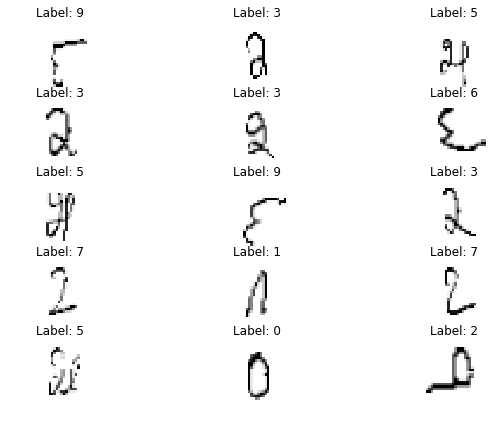

In [13]:
batch_show(train_data, train_labels, n_images=15)

### Data preprocessing

In [14]:
# reshaping 2D ndarrays into 4D (#images, #channel, #width, #height)
# converting datasets into tensors
X_train = torch.tensor(train_data).view(-1, 1, 28, 28).type(torch.FloatTensor)
y_train = torch.tensor(train_labels).view(train_labels.shape[0], 1)

X_val = torch.tensor(val_data).view(-1, 1, 28, 28).type(torch.FloatTensor)
y_val = torch.tensor(val_labels).view(val_labels.shape[0], 1)

X_test = torch.tensor(test_data).view(-1, 1, 28, 28).type(torch.FloatTensor)

X_train.shape, y_train.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000, 1]))

In [15]:
# Normalize pixel values
X_train /= 255.0
X_val /= 255.0
X_test /= 255.0

In [16]:
class KannadaDataset(data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img, target = self.images[index], int(self.labels[index])
        return img, target
    
    @property
    def classes(self):
        return torch.unique(self.labels)
    
    @property
    def c(self):
        return len(torch.unique(self.labels))

In [17]:
bs = 64

trainset = KannadaDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)

valset = KannadaDataset(X_val, y_val)
valloader = torch.utils.data.DataLoader(valset, batch_size=bs, shuffle=True)

testloader = torch.utils.data.DataLoader(X_test, batch_size=bs, shuffle=False)

In [18]:
dataloader = {
    'train': trainloader,
    'val': valloader,
    'test': testloader
}

### Designing the Neural Network

In [19]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolution layer sees (28x28x1 tensor)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=1)
        # Convolution layer sees (14x14x16 tensor)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)        
        self.pool = nn.MaxPool2d(2,2)
        # dense layers after last conv and pooling layer
        self.fc1 = nn.Linear(in_features=7*7*32, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        # output layer
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten image input        
        x = x.view(-1, 7*7*32)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x

### Train the network

In [20]:
model = Net()
model = model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)

In [21]:
ephocs = 50

losses = {
    'train': [],
    'val': []
}
accuracies = {
    'train': [],
    'val': []
}

for e in range(ephocs):
    for phase in ['train', 'val']:
        running_loss = 0.0
        running_acc = 0.0
        
        for images, labels in dataloader[phase]:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            # moving inputs to appropriate device (GPU or CPU)
            images = images.to(device)
            labels = labels.to(device)
            
            # clear previous gradients
            optimizer.zero_grad()
            # make prediction
            logit = model.forward(images)
            # convert log_softmax values to probabilities
            ps = torch.exp(logit)
            # get the max probability values and classes
            top_p, top_c = torch.max(ps, dim=1)
            # calcualte the loss and then optimze it (back-propagation)
            loss = criterion(logit, labels)
            loss.backward()
            optimizer.step()
            
            # check the equality of predicted classes and true labels
            equals = (top_c == labels.view(*top_c.shape)).type(torch.FloatTensor)
            running_acc += torch.mean(equals).item()
            running_loss += loss.item()
        else:
            accuracies[phase].append(running_acc / len(dataloader[phase]))
            losses[phase].append(running_loss / len(dataloader[phase]))
    else:
        print(f'Ephoc {e+1}/{ephocs}:')
        print('-'*50)
        print('train_acc: {:.5f} - train_loss: {:.5f} ---- val_acc: {:.5f} - val_loss: {:.5f}'
              .format(accuracies['train'][-1],
                      losses['train'][-1],
                      accuracies['val'][-1],
                      losses['val'][-1]))
        print('\n')

Ephoc 1/50:
--------------------------------------------------
train_acc: 0.82344 - train_loss: 0.60196 ---- val_acc: 0.77783 - val_loss: 0.76187


Ephoc 2/50:
--------------------------------------------------
train_acc: 0.94901 - train_loss: 0.17119 ---- val_acc: 0.82998 - val_loss: 0.58187


Ephoc 3/50:
--------------------------------------------------
train_acc: 0.96245 - train_loss: 0.12336 ---- val_acc: 0.86367 - val_loss: 0.46182


Ephoc 4/50:
--------------------------------------------------
train_acc: 0.97072 - train_loss: 0.09756 ---- val_acc: 0.88740 - val_loss: 0.37268


Ephoc 5/50:
--------------------------------------------------
train_acc: 0.97620 - train_loss: 0.07964 ---- val_acc: 0.90107 - val_loss: 0.31583


Ephoc 6/50:
--------------------------------------------------
train_acc: 0.97998 - train_loss: 0.06638 ---- val_acc: 0.91836 - val_loss: 0.27199


Ephoc 7/50:
--------------------------------------------------
train_acc: 0.98248 - train_loss: 0.05898 ---- val

### Save model's and optimizer's paramaters to disk

In [24]:
# acc = round(accuracies['train'][-1], 4)
# loss = round(losses['train'][-1], 4)
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict()
#      }, output_dir + f'/stage1_acc-{acc}_loss-{loss}.pth')

### Plotting accuracies and losses

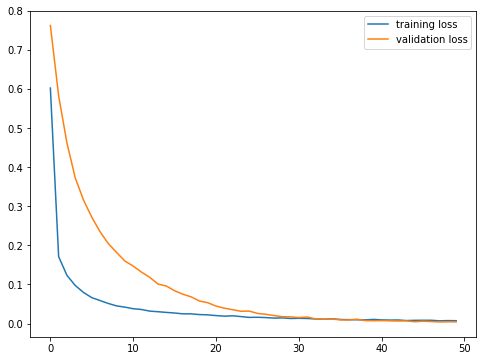

In [22]:
fig = plt.figure(figsize=(8, 6))
plt.plot(losses['train'], label='training loss')
plt.plot(losses['val'], label='validation loss')
plt.legend()
plt.show()

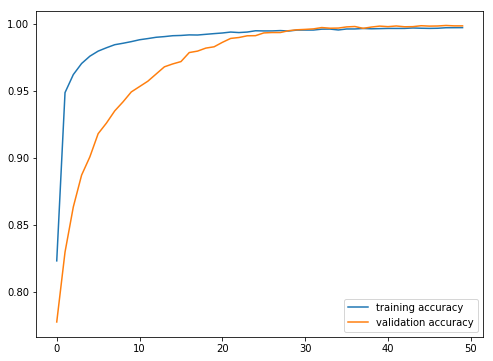

In [23]:
fig = plt.figure(figsize=(8, 6))
plt.plot(accuracies['train'], label='training accuracy')
plt.plot(accuracies['val'], label='validation accuracy')
plt.legend()
plt.show()

### Make Predictions

In [ ]:
# set model to evaluation mode
model.eval()
preds = []

for images in dataloader['test']:
    images = images.to(device)
    logit = model.forward(images)
    ps = torch.exp(logit)
    top_p, top_c = torch.max(ps, dim=1)
    preds.extend(top_c.to('cpu'))
    
preds = [p.item() for p in preds]

In [ ]:
len(preds)

In [ ]:
batch_show(test_data, preds, n_images=15)

### Save predictions and make submission

In [ ]:
submission_dict = {
    'id': test_csv['id'],
    'label': preds
}

submission_df = pd.DataFrame(data=submission_dict)
submission_df.head()

In [ ]:
submission_df.to_csv(output_dir + '/submission.csv', index=False)